In [315]:
import pyart
import numpy as np
import nexradaws
import tempfile
import xarray as xr
import time
import warnings
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

In [316]:
# Central lat/lon of ARM SGP site 
site_latlon = [36.607322, -97.487643]

In [317]:
radar_id = 'KVNX'
#start = datetime.datetime(2019,8,22,7,30) 
#end = datetime.datetime(2019,8,22,9,0)
start = datetime.datetime(2019,9,21,19,45)
end = datetime.datetime(2019,9,21,20,30)
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end)) 

There are 14 scans available between 2019-09-21 19:45:00 and 2019-09-21 20:30:00



In [318]:
# Create temp file, connect to NEXRAD AWS, request files by date & station ID
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()

count_scans = 0
good_scans = []
for i in range(len(scans)):
    this_str = str(scans[i])
    if this_str[-8::] != 'V06_MDM>':
        good_scans.append(scans[i])
        count_scans +=1
    else:
        print('Ignore:',this_str)
        i+=1
print(count_scans)

Ignore: <AwsNexradFile object - 2019/09/21/KVNX/KVNX20190921_195654_V06_MDM>
13


In [319]:
# Download selected volume scans
localfiles = conn.download(good_scans, templocation)

Downloaded KVNX20190921_195311_V06
Downloaded KVNX20190921_200436_V06
Downloaded KVNX20190921_194927_V06
Downloaded KVNX20190921_200050_V06
Downloaded KVNX20190921_200809_V06
Downloaded KVNX20190921_201141_V06
Downloaded KVNX20190921_195654_V06
Downloaded KVNX20190921_201515_V06
Downloaded KVNX20190921_201847_V06
Downloaded KVNX20190921_202225_V06
Downloaded KVNX20190921_202604_V06
Downloaded KVNX20190921_202930_V06
Downloaded KVNX20190921_194530_V06
13 out of 13 files downloaded...0 errors


In [320]:
sweep = np.arange(0, radar.nsweeps)

gate_lat_site = np.nan*np.ma.ones((count_scans,radar.nsweeps))
gate_lon_site = np.nan*np.ma.ones((count_scans,radar.nsweeps))
gate_hgt_site = np.nan*np.ma.ones((count_scans,radar.nsweeps))
Z_site = np.nan*np.ma.ones((count_scans,radar.nsweeps))
scan_times = []
j = 0 

# Loop through the volume scans
for scan in localfiles.iter_success():
    print('Reading in: '+scan.filename)

    # Read in the volume scans, get the times of the scans
    radar = pyart.io.read(localfiles.success[j].filepath)
    volume_scan_t = scan.scan_time
    scan_times.append(volume_scan_t)
    #print(j)

    # Loop through all the sweeps in a volume scan
    for i in range(radar.nsweeps):
        slice_start, slice_end = radar.get_start_end(i)
        gate_longitude = radar.gate_longitude['data'][slice_start:slice_end,:]
        gate_latitude = radar.gate_latitude['data'][slice_start:slice_end,:]
        gate_altitude = radar.gate_altitude['data'][slice_start:slice_end,:]

        # Find the gate closest to the desired site 
        # Get the lat,lon,alt,ref of the gate closest to the desired site
        dist = np.sqrt(((gate_latitude - site_latlon[0])**2) + ((gate_longitude - site_latlon[1])**2))
        index = np.where(dist == np.min(dist))
        gate_lat_site[j,i] = gate_latitude[index[0][0], index[1][0]]
        gate_lon_site[j,i] = gate_longitude[index[0][0], index[1][0]]
        gate_hgt_site[j,i] = gate_altitude[index[0][0], index[1][0]]
        Z_site[j,i] = radar.fields['reflectivity']['data'][slice_start+index[0][0], index[1][0]]

    #print(volume_scan_t)
    #print(Z_site)

    if j < (count_scans-1):
        j += 1
        del radar
    else:
        print('Done')
        #print(scan_times)
            
print(Z_site)

Reading in: KVNX20190921_194530_V06
Reading in: KVNX20190921_194927_V06
Reading in: KVNX20190921_195311_V06
Reading in: KVNX20190921_195654_V06
Reading in: KVNX20190921_200050_V06
Reading in: KVNX20190921_200436_V06
Reading in: KVNX20190921_200809_V06
Reading in: KVNX20190921_201141_V06
Reading in: KVNX20190921_201515_V06
Reading in: KVNX20190921_201847_V06
Reading in: KVNX20190921_202225_V06
Reading in: KVNX20190921_202604_V06
Reading in: KVNX20190921_202930_V06
Done
[[4.0 1.5 -5.0 -- -- -- -- -- -- -- -- -- -- -- nan nan]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- nan nan nan]
 [-2.5 -2.5 -4.5 -3.0 -- -- -- -- -- -- -- -- -- -- nan nan]
 [2.5 1.0 -- -- -- -- -- -- -- -- -- -- -- -- nan nan]
 [-2.5 -2.5 -- -- -- -- -- -- -- -- -- -- -- -- nan nan]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- nan nan nan]
 [-5.5 -- -- -- -- -- -- -- -- -- -- -- -- nan nan nan]
 [-- -- -- -- -5.5 -- -- -- -- -- -- -- -- nan nan nan]
 [0.0 -- -- -- -- -- -- -- -- -- -- -- -- nan nan nan]
 [-- -- -- -- -- -- --

In [324]:
# Create an xarray dataset with dimensions time and sweep
ds = xr.Dataset({'Z_site': (['time','sweep'], Z_site),
            'gate_lat_site': (['time','sweep'], gate_lat_site),
            'gate_lon_site': (['time','sweep'], gate_lon_site),
            },
            coords={'time': scan_times, 'sweep': sweep, 'gate_hgt_site': (['time','sweep'], gate_hgt_site)})

ds

<xarray.Dataset>
Dimensions:        (sweep: 16, time: 13)
Coordinates:
  * time           (time) object 2019-09-21T19:45:30+00:00 ... 2019-09-21T20:...
  * sweep          (sweep) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    gate_hgt_site  (time, sweep) float64 1.083e+03 1.083e+03 ... 1.705e+04
Data variables:
    Z_site         (time, sweep) float64 4.0 1.5 -5.0 nan ... nan nan nan nan
    gate_lat_site  (time, sweep) float64 36.61 36.61 36.61 ... 36.61 36.61 36.61
    gate_lon_site  (time, sweep) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49

In [309]:
# Add units
Z_site.attrs = ds.Z_site.attrs
Z_site.attrs["units"] = "dBZ"
gate_hgt_site.attrs = ds.gate_hgt_site.attrs
gate_hgt_site.attrs['units'] = 'Meters'

In [328]:
#radar.info()

Text(0.5, 1.0, 'Reflectivity above ARM SGP Site')

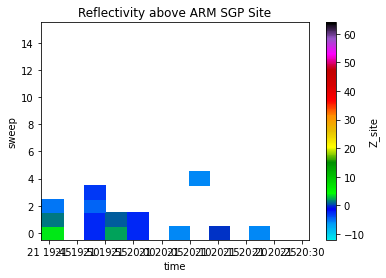

In [326]:
ds.Z_site.plot(x='time', y='sweep', vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
plt.title('Reflectivity above ARM SGP Site')

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

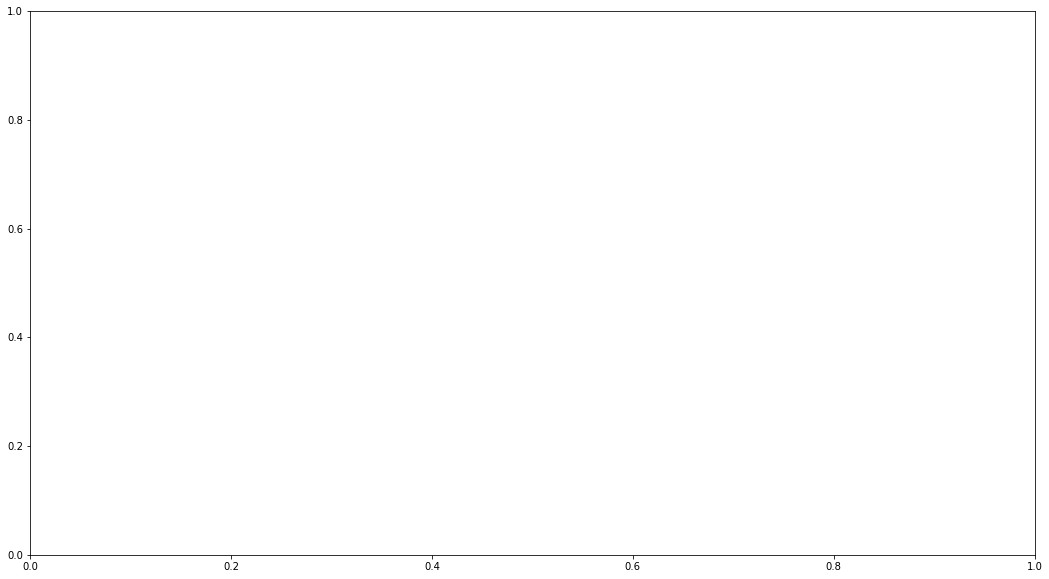

In [325]:
fig = plt.figure(figsize = [18,10])
plt.pcolormesh(ds.time, ds.gate_hgt_site, ds.Z_site,
               vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
plt.colorbar(label='NEXRAD Z (dBZ)')
plt.xlabel('Time', size=15)
plt.ylabel('Gate Height (m)', size=15)

t = ds.time.values
plt.ylim(0,17500)
plt.xticks(ticks=t, labels=t)
fig.autofmt_xdate()
plt.title('Reflectivity above ARM SGP Site', size=20)